In [1]:
#modules
from IPython.display import Image
import os
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.tri as tri
import time

In [2]:
#settings
path='./'
fig_dir = "./figures/"
data_dir = os.environ.get('OGS_DATA_DIR', '../../../Data')
out_dir = os.environ.get('OGS_TESTRUNNER_OUT_DIR', '_out')
exe_dir = "/home/ok/ogs/release/bin/" #relative path needed
prj_name = "axisym_theis"
prj_file = f"{prj_name}.prj"
pvd_name = "liquid_pcs"
vtu_name = "axisym_theis.vtu"
title = "H process: Theis solution (Pumping well)"

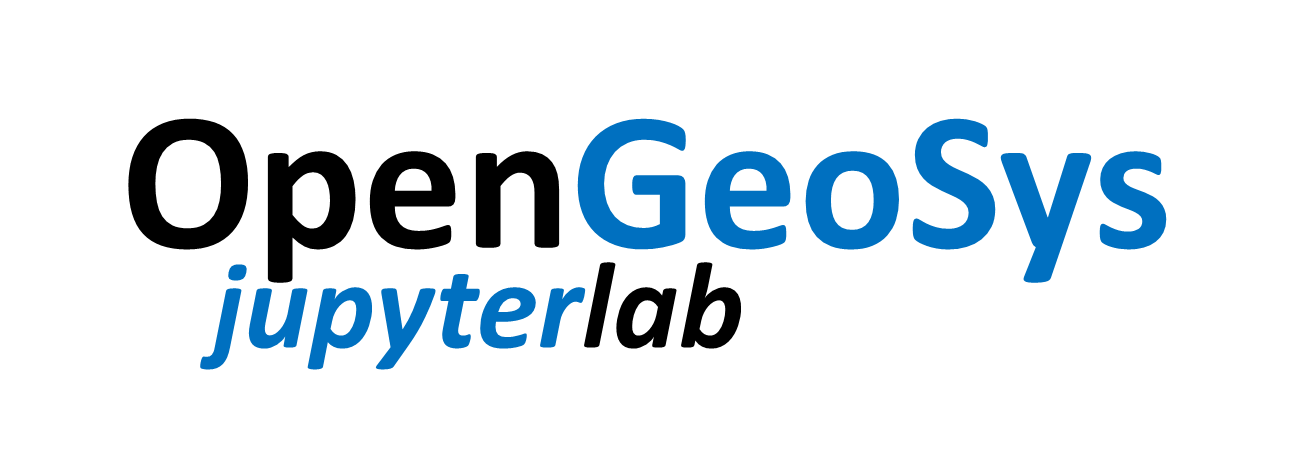

In [3]:
Image(filename = fig_dir + "ogs-jupyter-lab.png", width=150, height=100)

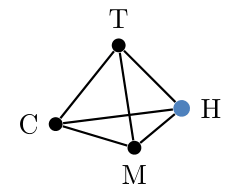

In [4]:
Image(filename = fig_dir + "h-tet-1.png", width=150, height=100)

## H process: Theis solution

**Problem description**

Theis’ problem examines the transient lowering of the water table induced by a pumping well. 
The assumptions required by the Theis solution are:

The aquifer 
- is homogeneous, isotropic, confined, infinite in radial extent,
- has uniform thickness, horizontal piezometric surface.

The well
- is fully penetrating the entire aquifer thickness,
- has a constant pumping rate,
- well storage effects can be neglected,
- no other wells or long term changes in regional water levels.

**Analytical solution**

The analytical solution of the drawdown as a function of time and distance is expressed by
$$
s(r,t) = h_0 - h(r,t) = \frac{Q}{4\pi T}W(u), \quad \mathrm{where}\quad u = \frac{r^2S}{4Tt}.
$$

where
- $s$ [$L$] is the _drawdown_ or change in hydraulic head,
- $h_0$ is the constant initial hydraulic head,
- $h$ is the hydrauic head at distance $r$ at time $t$
- $Q$ [$L^3T^{-1}$] is the constant pumping (discharge) rate
- $S$ [$-$] is the aquifer storage coefficient (volume of water released per unit decrease in $h$ per unit area)
- $T$ [$L^2T^{-1}$] is the transmissivity (a measure of how much water is transported horizontally per unit time).

The _Well Function_, $W(u)$ is the exponential integral, $E_1(u).$
$W(u)$ is defined by an infinite series:
$$
W(u) = - \gamma - \ln u + \sum_{k=1}^\infty \frac{(-1)^{k+1} u^k}{k \cdot k!}
$$
where
- $\gamma=0.577215664$ is the Euler-Mascheroni constant

For practical applications an approximation to the exponential integral is used often:
$$W(u) \approx -\gamma - \ln u$$

This results in an expression for $s(r,t)$ known as the Jacob equation:
$$
s(r,t) = -\frac{Q}{4\pi T}\left(\gamma + \ln u \right).
$$
For more details we refer to Srivastava and Guzman-Guzman (1998).

In [5]:
#source: https://scipython.com/blog/linear-and-non-linear-fitting-of-the-theis-equation/

def calc_u(r, S, T, t):
    """Calculate and return the dimensionless time parameter, u."""

    return r**2 * S / 4 / T / t

def theis_drawdown(t, S, T, Q, r):
    """Calculate and return the drawdown s(r,t) for parameters S, T.

    This version uses the Theis equation, s(r,t) = Q * W(u) / (4.pi.T),
    where W(u) is the Well function for u = Sr^2 / (4Tt).
    S is the aquifer storage coefficient,
    T is the transmissivity (m2/day),
    r is the distance from the well (m), and
    Q is the pumping rate (m3/day).

    """

    u = calc_u(r, S, T, t)
    s_theis = Q/4/np.pi/T * exp1(u)
    return s_theis
 

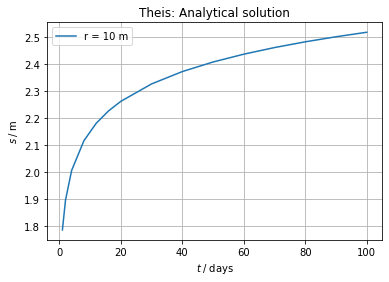

In [6]:
Q = 2000        # Pumping rate from well (m3/day)
r = 10          # Distance from well (m)

# Time grid, days.
t = np.array([1, 2, 4, 8, 12, 16, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Calculate some synthetic data to fit.
S, T = 0.0003, 1000
s = theis_drawdown(t, S, T, Q, r)

# Plot the data
titlestring = "Theis: Analytical solution"
plt.title(titlestring)
plt.plot(t, s, label='r = '+str(r)+' m')
plt.xlabel(r'$t\;/\;\mathrm{days}$')
plt.ylabel(r'$s\;/\;\mathrm{m}$')
plt.legend()
plt.grid()
plt.show()

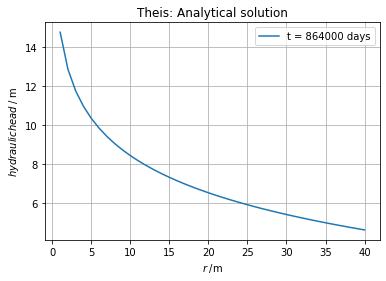

In [7]:
# Recalculation from days in sec
Q = 0.016      # Pumping rate from well (m3/s)
t = 864000     # Time in s.

# Distance from well (m)
##r = np.array([0.5, 1, 2, 4, 8, 12, 16, 20, 25, 30, 35, 40])
r = np.arange(1,41,1)
##print(r)

# Calculate some synthetic data to fit.
S = 0.001
T = 9.2903e-4
u = calc_u(r, S, T, t)
s = theis_drawdown(t, S, T, Q, r)
s = s-5 #reference head

# Plot the data
titlestring = "Theis: Analytical solution"
plt.title(titlestring)
plt.plot(r, s, label='t = '+str(t)+' days')
plt.xlabel(r'$r\;/\mathrm{m}$')
plt.ylabel(r'$hydraulic head\;/\;\mathrm{m}$')
plt.legend()
plt.grid()
plt.show()

**Numerical solution**

In [8]:
mesh = pv.read(vtu_name)
print("inspecting vtu-file")
mesh

inspecting vtu-file


UnstructuredGrid (0x7f1f3f9f78e0)
  N Cells:	354
  N Points:	476
  X Bounds:	3.048e-01, 3.048e+02
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	1

inspecting mesh and initial conditions


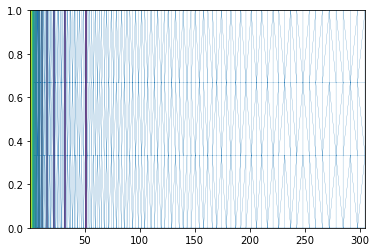

In [9]:
print("inspecting mesh and initial conditions")
#file
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(vtu_name)
reader.Update()  # Needed because of GetScalarRange
data = reader.GetOutput()
pressure = data.GetPointData().GetArray("OGS5_pressure")
#points
points = data.GetPoints()
npts = points.GetNumberOfPoints()
x = vtk_to_numpy(points.GetData())
triang = tri.Triangulation(x[:,0], x[:,1])
#plt.triplot(triang, 'go-', lw=1.0)
plt.triplot(triang,lw=0.2)
plt.tricontour(triang, pressure, 16)

**Running OGS**

In [10]:
#run ogs
t0 = time.time()
print("run ogs")
print(f"{exe_dir}ogs {prj_file} > log.txt")
#! {exe_dir}ogs {prj_file} > log.txt
! ogs {prj_file} > log.txt
tf = time.time()
print("computation time: ", round(tf - t0, 2), " s.")

run ogs
/home/ok/ogs/release/bin/ogs axisym_theis.prj > log.txt
computation time:  0.48  s.


**Spatial Profiles**

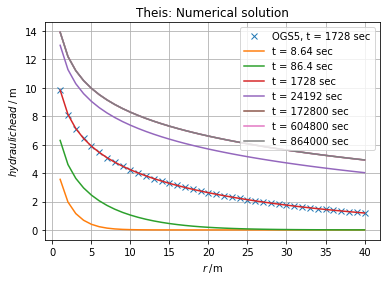

In [15]:
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
#Read simulation results
pvdfile = vtuIO.PVDIO(f"{pvd_name}.pvd", dim=2)
xaxis =  [(i,0,0) for i in np.linspace(start=1.0, stop=40, num=40)]
##print(xaxis)
r_x = np.array(xaxis)[:,0]
time = [8.64,86.4,1728,24192,172800,604800,864000]

pressure_xaxis_t = pvdfile.read_set_data(t, 'OGS5_pressure', data_type="point", pointsetarray=xaxis)

plt.plot(r_x, pressure_xaxis_t, 'x', label='OGS5, t = 1728 sec')

for t in time:
    pressure_xaxis_t = pvdfile.read_set_data(t, 'pressure', data_type="point", pointsetarray=xaxis)
    plt.plot(r_x, pressure_xaxis_t, label='t = '+str(t)+' sec')
titlestring = "Theis: Numerical solution"
plt.title(titlestring)
plt.xlabel(r'$r\;/\mathrm{m}$')
plt.ylabel(r'$hydraulic head\;/\;\mathrm{m}$')
plt.legend()
plt.grid()
#plt.savefig("theis.png")
plt.show()

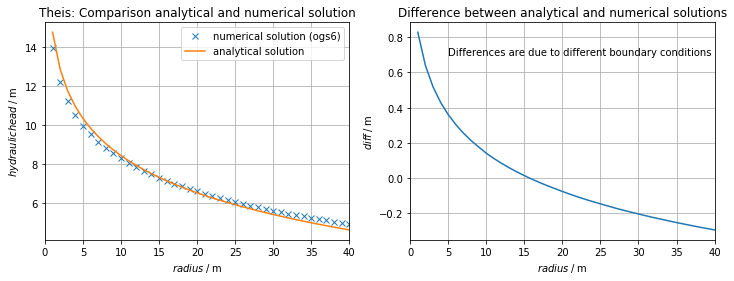

In [12]:
time = [864000]
pressure_xaxis_t = pvdfile.read_set_data(t, 'pressure', data_type="point", pointsetarray=xaxis)
#plot configuration
##plt.rcParams['figure.figsize'] = (16, 6)
##plt.rcParams['font.size'] = 12
##fig1, (ax1, ax2) = plt.subplots(1, 2)

fig, ax=plt.subplots(ncols=2, figsize=(12,4))
titlestring = "Theis: Comparison analytical and numerical solution"
ax[0].set_title(titlestring)
ax[0].set_xlim(0,40)
ax[0].plot(r_x, pressure_xaxis_t, 'x', label='numerical solution (ogs6)')
ax[0].plot(r, s, label='analytical solution')
ax[0].set_xlabel(r'$radius\;/\;\mathrm{m}$')
ax[0].set_ylabel(r'$hydraulic head\;/\;\mathrm{m}$')
ax[0].grid()
ax[0].legend()

##diff = np.setdiff1d(s,pressure_xaxis_t,assume_unique=False)
##print(diff)
titlestring = "Difference between analytical and numerical solutions"
caption = "Differences are due to different boundary conditions"
ax[1].set_title(titlestring)
ax[1].set_xlim(0,40)
ax[1].plot(r, s-pressure_xaxis_t, label='')
ax[1].set_xlabel(r'$radius\;/\;\mathrm{m}$')
ax[1].set_ylabel(r'$diff\;/\;\mathrm{m}$')
ax[1].grid()
ax[1].text(5,0.7,caption,ha='left')

##plt.savefig("theis-ana+num.png")
plt.show()

In [13]:
import time
print(time.ctime())

Wed Aug 24 23:22:23 2022


**OGS links**
- description: https://www.opengeosys.org/docs/benchmarks/
- project file: https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/LiquidFlow/AxiSymTheis/axisym_theis.prj

**References**
- Rajesh Srivastava and Amado Guzman-Guzman (1998): Practical Approximations of the Well Function. Groundwater, 36(5): 844-848, https://doi.org/10.1111/j.1745-6584.1998.tb02203.x

**Credits**
- Christian for the analytical solution in Python, https://scipython.com/blog/linear-and-non-linear-fitting-of-the-theis-equation/
- Wenqing Wang for set-up the OGS benchmark, https://www.opengeosys.org/docs/benchmarks/liquid-flow/liquid-flow-theis-problem/
- Jörg Buchwald for ogs6py and VTUInterface, https://joss.theoj.org/papers/6ddcac13634c6373e6e808952fdf4abc